# Import libraries

In [784]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
import plotly.graph_objects as go
import joblib  
from statsmodels.tsa.arima.model import ARIMA



In [785]:
data = pd.read_csv("../data/clean_data.csv")
data

,state,location,type,so2,no2,rspm,spm,date
0,Andhra Pradesh,Hyderabad,Residential,4.8,17.4,0.0,0.0,1990-02-01
1,Andhra Pradesh,Hyderabad,Industrial,3.1,7.0,0.0,0.0,1990-02-01
2,Andhra Pradesh,Hyderabad,Residential,6.2,28.5,0.0,0.0,1990-02-01
3,Andhra Pradesh,Hyderabad,Residential,6.3,14.7,0.0,0.0,1990-03-01
4,Andhra Pradesh,Hyderabad,Industrial,4.7,7.5,0.0,0.0,1990-03-01
...,...,...,...,...,...,...,...,...
434588,West Bengal,ULUBERIA,Residential,20.0,44.0,148.0,0.0,2015-12-15
434589,West Bengal,ULUBERIA,Residential,17.0,44.0,131.0,0.0,2015-12-18
434590,West Bengal,ULUBERIA,Residential,18.0,45.0,140.0,0.0,2015-12-21
434591,West Bengal,ULUBERIA,Residential,22.0,50.0,143.0,0.0,2015-12-24


# Calculate AQI

In [786]:
def calculate_si(so2):
    si=0
    if (so2<=40):
     si= so2*(50/40)
    if (so2>40 and so2<=80):
     si= 50+(so2-40)*(50/40)
    if (so2>80 and so2<=380):
     si= 100+(so2-80)*(100/300)
    if (so2>380 and so2<=800):
     si= 200+(so2-380)*(100/800)
    if (so2>800 and so2<=1600):
     si= 300+(so2-800)*(100/800)
    if (so2>1600):
     si= 400+(so2-1600)*(100/800)
    return si
data['si']=data['so2'].apply(calculate_si)
df= data[['so2','si']]
df.head()

,so2,si
0,4.8,6.000
1,3.1,3.875
2,6.2,7.750
3,6.3,7.875
4,4.7,5.875


In [787]:
def calculate_ni(no2):
    ni=0
    if(no2<=40):
     ni= no2*50/40
    elif(no2>40 and no2<=80):
     ni= 50+(no2-14)*(50/40)
    elif(no2>80 and no2<=180):
     ni= 100+(no2-80)*(100/100)
    elif(no2>180 and no2<=280):
     ni= 200+(no2-180)*(100/100)
    elif(no2>280 and no2<=400):
     ni= 300+(no2-280)*(100/120)
    else:
     ni= 400+(no2-400)*(100/120)
    return ni
data['ni']=data['no2'].apply(calculate_ni)
df= data[['no2','ni']]
df.head()

,no2,ni
0,17.4,21.750
1,7.0,8.750
2,28.5,35.625
3,14.7,18.375
4,7.5,9.375


In [788]:
def calculate_(rspm):
    rpi=0
    if(rspm<=30):
     rpi=rspm*50/30
    elif(rspm>30 and rspm<=60):
     rpi=50+(rspm-30)*50/30
    elif(rspm>60 and rspm<=90):
     rpi=100+(rspm-60)*100/30
    elif(rspm>90 and rspm<=120):
     rpi=200+(rspm-90)*100/30
    elif(rspm>120 and rspm<=250):
     rpi=300+(rspm-120)*(100/130)
    else:
     rpi=400+(rspm-250)*(100/130)
    return rpi
data['rpi']=data['rspm'].apply(calculate_si)
df= data[['rspm','rpi']]
df.tail()

,rspm,rpi
434588,148.0,122.666667
434589,131.0,117.000000
434590,140.0,120.000000
434591,143.0,121.000000
434592,171.0,130.333333


In [789]:
def calculate_spi(spm):
    spi=0
    if(spm<=50):
     spi=spm
    if(spm<50 and spm<=100):
     spi=spm
    elif(spm>100 and spm<=250):
     spi= 100+(spm-100)*(100/150)
    elif(spm>250 and spm<=350):
     spi=200+(spm-250)
    elif(spm>350 and spm<=450):
     spi=300+(spm-350)*(100/80)
    else:
     spi=400+(spm-430)*(100/80)
    return spi
data['spi']=data['spm'].apply(calculate_spi)
df= data[['spm','spi']]
df.head()
#many data values of rspm values is unawailable since it was not measure before

,spm,spi
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [790]:
#function to calculate the air quality index (AQI) of every data value
#its is calculated as per indian govt standards
def calculate_aqi(si,ni,spi,rpi):
    aqi=0
    if(si>ni and si>spi and si>rpi):
     aqi=si
    if(spi>si and spi>ni and spi>rpi):
     aqi=spi
    if(ni>si and ni>spi and ni>rpi):
     aqi=ni
    if(rpi>si and rpi>ni and rpi>spi):
     aqi=rpi
    return aqi
data['AQI']=data.apply(lambda x:calculate_aqi(x['si'],x['ni'],x['spi'],x['rpi']),axis=1)
df= data[['date','type','si','ni','rpi','spi','AQI']]
df.head()

,date,type,si,ni,rpi,spi,AQI
0,1990-02-01,Residential,6.000,21.750,0.0,0.0,21.750
1,1990-02-01,Industrial,3.875,8.750,0.0,0.0,8.750
2,1990-02-01,Residential,7.750,35.625,0.0,0.0,35.625
3,1990-03-01,Residential,7.875,18.375,0.0,0.0,18.375
4,1990-03-01,Industrial,5.875,9.375,0.0,0.0,9.375


In [791]:
def outlier_clean(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # กำหนดช่วงที่ไม่มี Outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier = df[(df <= lower_bound) | (df >= upper_bound)]
    print(f"Outlier count :{outlier.count()}")
    # ลบ Outliers
    return df[(df >= lower_bound) & (df <= upper_bound)]

aqi_clean_data = outlier_clean(df["AQI"])
print(aqi_clean_data)
df.iloc[aqi_clean_data.index]
df.reset_index(drop=True)
df

Outlier count :40163
0          21.750000
1           8.750000
2          35.625000
3          18.375000
4           9.375000
             ...    
434588    122.666667
434589    117.000000
434590    120.000000
434591    121.000000
434592    130.333333
Name: AQI, Length: 394430, dtype: float64


,date,type,si,ni,rpi,spi,AQI
0,1990-02-01,Residential,6.000,21.750,0.000000,0.0,21.750000
1,1990-02-01,Industrial,3.875,8.750,0.000000,0.0,8.750000
2,1990-02-01,Residential,7.750,35.625,0.000000,0.0,35.625000
3,1990-03-01,Residential,7.875,18.375,0.000000,0.0,18.375000
4,1990-03-01,Industrial,5.875,9.375,0.000000,0.0,9.375000
...,...,...,...,...,...,...,...
434588,2015-12-15,Residential,25.000,87.500,122.666667,0.0,122.666667
434589,2015-12-18,Residential,21.250,87.500,117.000000,0.0,117.000000
434590,2015-12-21,Residential,22.500,88.750,120.000000,0.0,120.000000
434591,2015-12-24,Residential,27.500,95.000,121.000000,0.0,121.000000


In [792]:
# df_duplicate = df
# df_duplicate["count"] = 0
# state_len = df["state"].unique()
# print(len(state_len))

In [793]:
# # Convert date column to datetime
# df["date"] = pd.to_datetime(df["date"])
# df=df.set_index('date').resample('M')["AQI"].mean()
# df
# df.to_csv('../data/cal1.csv', index=True)

In [794]:
# Convert the 'date' column to datetime
df["date"] = pd.to_datetime(df["date"])

# Select only numeric columns before applying mean
numeric_cols = df.select_dtypes(include=['number']).columns

# Group by year and month, calculate mean for numeric columns
monthly_mean = df.groupby(df["date"].dt.to_period("M"))[numeric_cols].mean()

# Drop the original 'date' column (not needed in the resulting DataFrame)
monthly_mean = monthly_mean.drop(columns=['date'], errors='ignore')

# Reset index to turn 'period' into a regular column
monthly_mean.reset_index(inplace=True)

# Rename the index column to 'period'
monthly_mean.rename(columns={"date": "period"}, inplace=True)

# Convert 'period' to datetime if desired
monthly_mean['date'] = monthly_mean['period'].dt.to_timestamp()

# Optional: Drop the 'date' column if it's no longer needed
monthly_mean = monthly_mean.drop(columns=['date'], errors='ignore')

# Show the first few rows to verify the result
print(monthly_mean.head())

# Save to CSV
monthly_mean.to_csv('../data/cal.csv', index=False)

    period         si         ni  rpi         spi         AQI
0  1987-01  18.500236  29.364184  0.0  238.133570  242.438652
1  1987-02  20.948652  36.680515  0.0  227.525123  235.787929
2  1987-03  21.848099  38.427632  0.0  286.692982  294.558772
3  1987-04  19.945652  27.054348  0.0  195.811594  202.012681
4  1987-05  19.043750  37.813750  0.0  302.379167  307.991667


C:\Users\onero\AppData\Local\Temp\ipykernel_28888\3885041429.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [795]:
monthly_mean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   period  346 non-null    period[M]
 1   si      346 non-null    float64  
 2   ni      346 non-null    float64  
 3   rpi     346 non-null    float64  
 4   spi     346 non-null    float64  
 5   AQI     346 non-null    float64  
dtypes: float64(5), period[M](1)
memory usage: 16.3 KB


In [796]:
plot_monthly = monthly_mean
plot_monthly["period"] = monthly_mean["period"].astype(str)

fig_new = go.Figure()

# Add new data actual AQI (if available)
fig_new.add_trace(go.Scatter(x=plot_monthly['period'], y=plot_monthly['AQI'],
                                mode='lines', name='Actual AQI',
                                line=dict(color='blue')))



# Upperiod layout
fig_new.update_layout(
    title='Mean AQI in each month (1987 - 2015)',
    xaxis_title='period',
    yaxis_title='AQI',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

# Show the plot
fig_new.show()


# ARiMA Model



In [797]:
df.rename(columns={"date": "period"}, inplace=True)
df

C:\Users\onero\AppData\Local\Temp\ipykernel_28888\3976715143.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,period,type,si,ni,rpi,spi,AQI
0,1990-02-01,Residential,6.000,21.750,0.000000,0.0,21.750000
1,1990-02-01,Industrial,3.875,8.750,0.000000,0.0,8.750000
2,1990-02-01,Residential,7.750,35.625,0.000000,0.0,35.625000
3,1990-03-01,Residential,7.875,18.375,0.000000,0.0,18.375000
4,1990-03-01,Industrial,5.875,9.375,0.000000,0.0,9.375000
...,...,...,...,...,...,...,...
434588,2015-12-15,Residential,25.000,87.500,122.666667,0.0,122.666667
434589,2015-12-18,Residential,21.250,87.500,117.000000,0.0,117.000000
434590,2015-12-21,Residential,22.500,88.750,120.000000,0.0,120.000000
434591,2015-12-24,Residential,27.500,95.000,121.000000,0.0,121.000000


In [798]:
new_data_A = monthly_mean
new_data_A

,period,si,ni,rpi,spi,AQI
0,1987-01,18.500236,29.364184,0.000000,238.133570,242.438652
1,1987-02,20.948652,36.680515,0.000000,227.525123,235.787929
2,1987-03,21.848099,38.427632,0.000000,286.692982,294.558772
3,1987-04,19.945652,27.054348,0.000000,195.811594,202.012681
4,1987-05,19.043750,37.813750,0.000000,302.379167,307.991667
...,...,...,...,...,...,...
341,2015-08,9.173266,26.788795,79.739118,0.000000,80.745975
342,2015-09,9.110393,28.942988,87.162823,0.000000,87.668083
343,2015-10,10.090212,33.098520,95.827394,0.000000,96.306726
344,2015-11,10.655378,36.704568,102.478454,0.000000,102.913944


In [799]:
# new_data_A = monthly_mean.iloc[:,[0,5]]
new_data_A['period'] = pd.to_datetime(new_data_A['period'])
new_data_A.set_index('period', inplace=True)
new_data_A


,si,ni,rpi,spi,AQI
period,,,,,
1987-01-01,18.500236,29.364184,0.000000,238.133570,242.438652
1987-02-01,20.948652,36.680515,0.000000,227.525123,235.787929
1987-03-01,21.848099,38.427632,0.000000,286.692982,294.558772
1987-04-01,19.945652,27.054348,0.000000,195.811594,202.012681
1987-05-01,19.043750,37.813750,0.000000,302.379167,307.991667
...,...,...,...,...,...
2015-08-01,9.173266,26.788795,79.739118,0.000000,80.745975
2015-09-01,9.110393,28.942988,87.162823,0.000000,87.668083
2015-10-01,10.090212,33.098520,95.827394,0.000000,96.306726


In [800]:
new_data_A['AQI'] = new_data_A['AQI'].interpolate(method='linear')
new_data_A

,si,ni,rpi,spi,AQI
period,,,,,
1987-01-01,18.500236,29.364184,0.000000,238.133570,242.438652
1987-02-01,20.948652,36.680515,0.000000,227.525123,235.787929
1987-03-01,21.848099,38.427632,0.000000,286.692982,294.558772
1987-04-01,19.945652,27.054348,0.000000,195.811594,202.012681
1987-05-01,19.043750,37.813750,0.000000,302.379167,307.991667
...,...,...,...,...,...
2015-08-01,9.173266,26.788795,79.739118,0.000000,80.745975
2015-09-01,9.110393,28.942988,87.162823,0.000000,87.668083
2015-10-01,10.090212,33.098520,95.827394,0.000000,96.306726


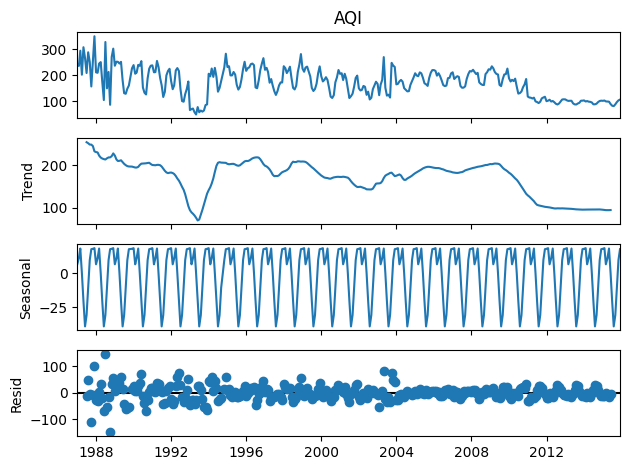

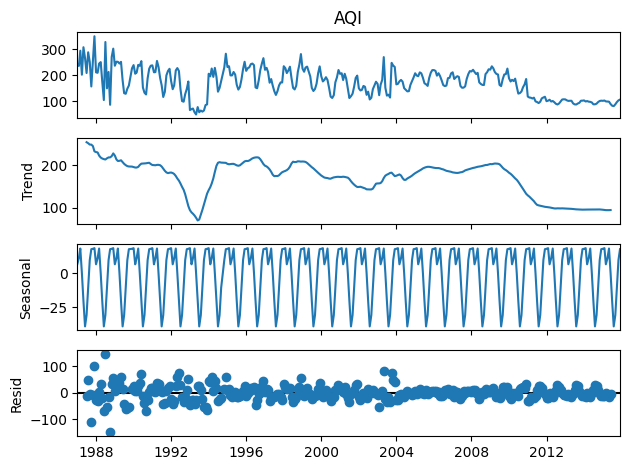

In [801]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(new_data_A['AQI'], model='additive', period=12)
result.plot()

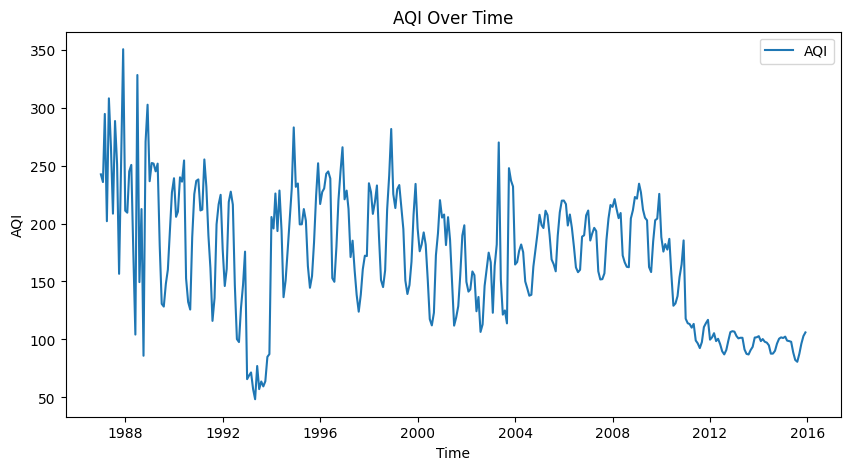

In [802]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(new_data_A.index, new_data_A['AQI'], label='AQI')
plt.title('AQI Over Time')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend()
plt.show()

In [803]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(new_data_A['AQI'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -2.8099020513809725
p-value: 0.056873192395829934


In [804]:
new_data_A['log_AQI'] = np.log(new_data_A['AQI'])

# ADF test on log-transformed data
adf_result = adfuller(new_data_A['log_AQI'].dropna())  # Drop NaNs if any are introduced
print(f'ADF Statistic (Log): {adf_result[0]}')
print(f'p-value (Log): {adf_result[1]}')

# Check stationarity and apply differencing if necessary
if adf_result[1] >= 0.05:
    # First differencing
    new_data_A['log_diff_AQI'] = new_data_A['log_AQI'].diff()
    adf_result_diff = adfuller(new_data_A['log_diff_AQI'].dropna())
    print(f'ADF Statistic (Log + Diff): {adf_result_diff[0]}')
    print(f'p-value (Log + Diff): {adf_result_diff[1]}')

ADF Statistic (Log): -3.0495887793008887
p-value (Log): 0.03051583359674713


In [805]:
plot_data_A = new_data_A.reset_index()
plot_data_A["period"] = plot_data_A["period"].astype(str)
fig_new = go.Figure()

# Add new data actual AQI (if available)
fig_new.add_trace(go.Scatter(x=plot_data_A['period'], y=plot_data_A['log_AQI'],
                                mode='lines', name='Actual AQI',
                                line=dict(color='blue')))



# Upperiod layout
fig_new.update_layout(
    title='Log AQI in each month (1987 - 2015)',
    xaxis_title='period',
    yaxis_title='AQI',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

# Show the plot
fig_new.show()

In [806]:
new_data_B = new_data_A.iloc[:340,5]
new_data_B

period
1987-01-01    5.490749
1987-02-01    5.462933
1987-03-01    5.685479
1987-04-01    5.308330
1987-05-01    5.730073
                ...   
2015-02-01    4.629401
2015-03-01    4.595108
2015-04-01    4.590966
2015-05-01    4.584907
2015-06-01    4.486562
Name: log_AQI, Length: 340, dtype: float64

In [807]:
new_data_A

,si,ni,rpi,spi,AQI,log_AQI
period,,,,,,
1987-01-01,18.500236,29.364184,0.000000,238.133570,242.438652,5.490749
1987-02-01,20.948652,36.680515,0.000000,227.525123,235.787929,5.462933
1987-03-01,21.848099,38.427632,0.000000,286.692982,294.558772,5.685479
1987-04-01,19.945652,27.054348,0.000000,195.811594,202.012681,5.308330
1987-05-01,19.043750,37.813750,0.000000,302.379167,307.991667,5.730073
...,...,...,...,...,...,...
2015-08-01,9.173266,26.788795,79.739118,0.000000,80.745975,4.391308
2015-09-01,9.110393,28.942988,87.162823,0.000000,87.668083,4.473558
2015-10-01,10.090212,33.098520,95.827394,0.000000,96.306726,4.567538


In [808]:
from pmdarima import auto_arima
model = auto_arima(new_data_B, seasonal=False, trace=True)
arima_forecast = model.predict(n_periods=6)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-119.410, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-86.039, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-94.477, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-96.384, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-87.973, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-118.246, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-118.271, Time=0.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-122.408, Time=0.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-122.750, Time=0.39 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-113.112, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-124.177, Time=0.60 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-115.633, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-122.864, Time=0.78 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-120.449, Time=0.44 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   :

c:\Users\onero\Desktop\Dumb\swu\indian-air\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\onero\Desktop\Dumb\swu\indian-air\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [809]:
arima_forecast

340    4.512040
341    4.522112
342    4.549118
343    4.550015
344    4.554003
345    4.552753
dtype: float64

In [810]:
monthly_mean

,si,ni,rpi,spi,AQI,log_AQI
period,,,,,,
1987-01-01,18.500236,29.364184,0.000000,238.133570,242.438652,5.490749
1987-02-01,20.948652,36.680515,0.000000,227.525123,235.787929,5.462933
1987-03-01,21.848099,38.427632,0.000000,286.692982,294.558772,5.685479
1987-04-01,19.945652,27.054348,0.000000,195.811594,202.012681,5.308330
1987-05-01,19.043750,37.813750,0.000000,302.379167,307.991667,5.730073
...,...,...,...,...,...,...
2015-08-01,9.173266,26.788795,79.739118,0.000000,80.745975,4.391308
2015-09-01,9.110393,28.942988,87.162823,0.000000,87.668083,4.473558
2015-10-01,10.090212,33.098520,95.827394,0.000000,96.306726,4.567538


In [811]:
new_data_p = np.exp(arima_forecast)
new_data_p

340    91.107479
341    92.029744
342    94.548980
343    94.633834
344    95.011999
345    94.893317
dtype: float64

In [812]:
actual_values = monthly_mean.iloc[340:,4]
forecasted_values = new_data_p
mse = mean_squared_error(actual_values, forecasted_values)
print(f'actual_values: \n{actual_values}')
print(f'forecasted_values: \n{forecasted_values}')

print(f'Mean Squared Error (MSE): {mse}')

r2 = r2_score(actual_values, forecasted_values)
print(f'R-squared (R²): {r2}')

joblib.dump(arima_forecast, '../results/output/arima_model.pkl')

actual_values: 
period
2015-07-01     82.353637
2015-08-01     80.745975
2015-09-01     87.668083
2015-10-01     96.306726
2015-11-01    102.913944
2015-12-01    106.081322
Name: AQI, dtype: float64
forecasted_values: 
340    91.107479
341    92.029744
342    94.548980
343    94.633834
344    95.011999
345    94.893317
dtype: float64
Mean Squared Error (MSE): 73.61844717231855
R-squared (R²): 0.22731407789080293


['../results/output/arima_model.pkl']

In [813]:
plot_result = new_data_A.reset_index()
plot_result["period"] = plot_result["period"].astype(str)
# new_data_p
forecasted_values = pd.DataFrame(new_data_p)
time_index = pd.date_range(start='2015-07-01', periods=len(forecasted_values), freq='M')
forecasted_values["period"] = time_index
forecasted_values = forecasted_values.rename(columns={0: 'AQI'})


fig_new = go.Figure()

# Original data trace
fig_new.add_trace(go.Scatter(
    x=plot_result['period'], 
    y=plot_result['AQI'],
    mode='lines', 
    name='Actual AQI',
    line=dict(color='blue'),
    hovertemplate='Date: %{x}<br>AQI: %{y:.2f}<extra></extra>'  # Custom hover text
))

# Forecasted data trace
fig_new.add_trace(go.Scatter(
    x=forecasted_values['period'], 
    y=forecasted_values['AQI'],
    mode='lines', 
    name='Prediction',
    line=dict(color='red', dash='dot'),
    hovertemplate='Date: %{x}<br>Predicted AQI: %{y:.2f}<extra></extra>'  # Custom hover text
))

# Enhanced interactive layout
fig_new.update_layout(
    title='AQI in each month (1987 - 2015)',
    xaxis_title='Period',
    yaxis_title='AQI',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    
    # Interactive features
    hovermode='x unified',  # Show all traces for a given x-position
    hoverdistance=100,      # Distance to show hover label
    spikedistance=1000,     # Distance to show spike
    
    # Add hover and spike lines
    xaxis=dict(
        showspikes=True,    # Show vertical spike line
        spikethickness=2,
        spikedash='dot',
        spikecolor="#999999",
        spikemode='across'
    ),
    yaxis=dict(
        showspikes=True,    # Show horizontal spike line
        spikethickness=2,
        spikedash='dot',
        spikecolor="#999999",
        spikemode='across'
    )
)


# Add range slider and selector
fig_new.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),  # Add range slider
        type="date"  # Ensure x-axis is treated as dates
    )
)

# Zoom and pan options
fig_new.update_layout(
    dragmode='zoom',  # Allow zooming by dragging
)

fig_new.show()

C:\Users\onero\AppData\Local\Temp\ipykernel_28888\128642802.py:5: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [814]:
forecasted_values

,AQI,period
340,91.107479,2015-07-31
341,92.029744,2015-08-31
342,94.548980,2015-09-30
343,94.633834,2015-10-31
344,95.011999,2015-11-30
345,94.893317,2015-12-31


# Prophet Model

In [815]:
data_A = monthly_mean.reset_index()
data_A = data_A.iloc[:,[0,6]]
data_A

,period,log_AQI
0,1987-01-01,5.490749
1,1987-02-01,5.462933
2,1987-03-01,5.685479
3,1987-04-01,5.308330
4,1987-05-01,5.730073
...,...,...
341,2015-08-01,4.391308
342,2015-09-01,4.473558
343,2015-10-01,4.567538
344,2015-11-01,4.633893


In [816]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
import plotly.graph_objects as go

# Ensure the date column is in datetime format
data_A['period'] = pd.to_datetime(data_A['period'], format='%Y-%m')

# Rename columns for Prophet
data_A = data_A.rename(columns={'period': 'ds', 'log_AQI': 'y'})


In [817]:
# Train-test split (use the last 20% of data_A as the test set)
test_size = 6
# train, test = data_A[:train_size], data_A[train_size:]
train, test = data_A.iloc[:-6],data_A.iloc[-6:]
print(train)
print(test)

            ds         y
0   1987-01-01  5.490749
1   1987-02-01  5.462933
2   1987-03-01  5.685479
3   1987-04-01  5.308330
4   1987-05-01  5.730073
..         ...       ...
335 2015-02-01  4.629401
336 2015-03-01  4.595108
337 2015-04-01  4.590966
338 2015-05-01  4.584907
339 2015-06-01  4.486562

[340 rows x 2 columns]
            ds         y
340 2015-07-01  4.411023
341 2015-08-01  4.391308
342 2015-09-01  4.473558
343 2015-10-01  4.567538
344 2015-11-01  4.633893
345 2015-12-01  4.664206


In [818]:

# Initialize the Prophet model
model = Prophet()

# Fit the model on the training data
model.fit(train)

# Make future dataframe (including the test set period)
future = model.make_future_dataframe(periods=test_size, freq='M')

# Get the forecasted values
forecast = model.predict(future)
forecast
# Extract the predictions for the test period

joblib.dump(model, '../results/output/prophet_model.pkl')


17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\onero\Desktop\Dumb\swu\indian-air\myenv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



['../results/output/prophet_model.pkl']

In [819]:
y_pred = forecast.loc[:,["ds","yhat"]][-test_size:]
print(test)
print(y_pred)

            ds         y
340 2015-07-01  4.411023
341 2015-08-01  4.391308
342 2015-09-01  4.473558
343 2015-10-01  4.567538
344 2015-11-01  4.633893
345 2015-12-01  4.664206
            ds      yhat
340 2015-06-30  3.979276
341 2015-07-31  4.167630
342 2015-08-31  4.066948
343 2015-09-30  4.475319
344 2015-10-31  4.490444
345 2015-11-30  4.645310


In [820]:
mse = mean_squared_error(test['y'], y_pred["yhat"])
r2 = r2_score(test['y'], y_pred["yhat"])

print(f"MSE on training set(Prophet): {mse}")
print(f"R² on training set(Prophet): {r2}")

# Create a Plotly Figure
fig = go.Figure()

# Add train data
fig.add_trace(go.Scatter(x=data_A['ds'], y=data_A['y'],
                         mode='lines', name='Train',
                         line=dict(color='blue')))

# Add test data
# fig.add_trace(go.Scatter(x=data['ds'], y=test['y'],
#                          mode='lines', name='Test',
#                          line=dict(color='green')))

# Add predictions
fig.add_trace(go.Scatter(x=y_pred['ds'], y=y_pred["yhat"],
                         mode='lines', name='Prediction',
                         line=dict(color='red', dash='dot')))

# Update layout
fig.update_layout(
    title='AQI Forecasting - Train, Test, and Predictions using Prophet',
    xaxis_title='Period',
    yaxis_title='AQI',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

# Show metrics in the plot
fig.add_annotation(
    x=data_A['ds'].iloc[-1],
    y=max(test['y'])+2,
    text=f"<br><b>MSE:</b> {mse:.2f}<br><b>R²:</b> {r2:.2f}",
    showarrow=False,
    font=dict(size=12, color="black"),
    align="left",
    bgcolor="rgba(255,255,255,0.7)",
    bordercolor="black",
    borderwidth=1
)

# Show the plot
fig.show()

MSE on training set(Prophet): 0.07186797817212605
R² on training set(Prophet): -5.480021712494315
